In [302]:
import numpy as np
import scipy.integrate as integrate
from scipy import linalg
import matplotlib.pyplot as plt

# Util functions

def plot_3d(grid:np.array, mesh:np.matrix, grid_name='t', mesh_name='x'):
    figure = plt.figure(figsize=(20, 20))
    
    one   = figure.add_subplot(2, 2, 1); one.set(title="$"+mesh_name+"_1$", xlabel=grid_name);   one.plot(grid, mesh[:, 0]);   one.grid('on')
    two   = figure.add_subplot(2, 2, 2); two.set(title="$"+mesh_name+"_2$", xlabel=grid_name);   two.plot(grid, mesh[:, 1]);   two.grid('on')
    three = figure.add_subplot(2, 2, 3); three.set(title="$"+mesh_name+"_3$", xlabel=grid_name); three.plot(grid, mesh[:, 2]); three.grid('on')
    four  = figure.add_subplot(2, 2, 4, projection='3d')
    four.set(title = 'Trajectory', xlabel="$"+mesh_name+"_1$", ylabel="$"+mesh_name+"_2$", zlabel="$"+mesh_name+"_3$")
    four.plot(mesh[:, 0], mesh[:, 1], mesh[:, 2], linewidth=2)
    
    return (figure, (one, two, three, four))

## Описание робота RHANTOM 1.5

In [303]:
class RobotIface:
    '''
        Robot's dynamics:
        Inertia(state)*state'' + Coriolis(state)*state' + Gravity(state) = tau
    '''
    def inertia(self:RobotIface, state:np.array) -> np.matrix:
        pass
    def coriolis(self:RobotIface, state:np.array) -> np.matrix:
        pass
    def gravity(self:RobotIface, state:np.array) -> np.matrix:
        pass
    '''
        Robot's regression dinamics:
        Inertia(state, param)*state'' + Coriolis(state, param)*state' + Gravity(state, param) = Y * param
    '''
    def initial_params(self:RobotIface) -> np.array:
        pass
    def inertia_p(self:RobotIface, state:np.array, param:np.array) -> np.matrix:
        pass
    def coriolis_p(self:RobotIface, state:np.array, param:np.array) -> np.matrix:
        pass
    def gravity_p(self:RobotIface, state:np.array, param:np.array) -> np.matrix:
        pass
    '''
        Robot's kinematics
    '''
    def forward_kinematics(self:RobotIface, state:np.array) -> np.array:
        pass
    def jacobian(self:RobotIface, state:np.array) -> np.matrix:
        pass
    def d_jacobian(self:RobotIface, state:np.array) -> np.matrix:
        pass

In [304]:
class Phantom(RobotIface):
    l = [0.215, 0.170, 0.0325, 0, -0.0368, 0.0527]
    m_a  = 0.0202
    m_c  = 0.0249
    m_be = 0.2359
    m_df = 0.1906
    i_axx = 0.4864/10000
    i_ayy = 0.0018/10000
    i_azz = 0.4864/10000
    i_cxx = 0.959/10000
    i_cyy = 0.959/10000
    i_czz = 0.0051/10000
    i_bexx = 11.09/10000
    i_beyy = 10.06/10000
    i_bezz = 0.591/10000
    i_dfxx = 7.11/10000
    i_dfyy = 0.629/10000
    i_dfzz = 6.246/10000
    i_baseyy = 11.87/10000
    g = 9.81

    def inertia(self:Phantom, state:np.array) -> np.matrix:
        result = np.zeros((3, 3))
        result[0, 0] = 1/8*(4*self.i_ayy+4*self.i_azz+8*self.i_baseyy+4*self.i_beyy+4*self.i_bezz+4*self.i_cyy+4*self.i_czz +4*self.i_dfyy+4*self.i_dfzz+4*self.l[0]**2*self.m_a+self.l[1]**2*self.m_a+self.l[0]**2*self.m_c+4*self.l[2]**2*self.m_c)+\
                1/8*(4*self.i_beyy-4*self.i_bezz+4*self.i_cyy-4*self.i_czz+self.l[0]**2*(4*self.m_a+self.m_c))*np.cos(2*state[1])+\
                1/8*(4*self.i_ayy-4*self.i_azz+4*self.i_dfyy-4*self.i_dfzz-self.l[1]**2*self.m_a-4*self.l[2]**2*self.m_c)*np.cos(2*state[2])+\
                self.l[0]*(self.l[1]*self.m_a+self.l[2]*self.m_c)*np.cos(state[1])*np.sin(state[2])
        result[1, 1] = 1/4*(4*(self.i_bexx+self.i_cxx+self.l[0]**2*self.m_a)+self.l[0]**2*self.m_c)
        result[1, 2] = -1/2*self.l[0]*(self.l[1]*self.m_a+self.l[2]*self.m_c)*np.sin(state[1]-state[2])
        result[2, 1] = result[1, 2]
        result[2, 2] = 1/4*(4*self.i_axx+4*self.i_dfxx+self.l[1]**2*self.m_a+4*self.l[2]**2*self.m_c)
        return result

    def coriolis(self:Phantom, state:np.array) -> np.matrix:
        s2 = np.sin(state[1]); c2 = np.cos(state[1])
        s3 = np.sin(state[2]); c3 = np.cos(state[2])

        result = np.zeros((3, 3))
        result[0, 0] = 1/8*(-2*s2*((4*self.i_beyy-4*self.i_bezz+4*self.i_cyy-4*self.i_czz+4*self.l[0]**2*self.m_a+self.l[0]**2*self.m_c)*c2+2*self.l[0]*(self.l[1]*self.m_a+self.l[2]*self.m_c)*s3)*state[4]+2*c3*(2*self.l[0]*(self.l[1]*self.m_a+self.l[2]*self.m_c)*c2+(-4*self.i_ayy+4*self.i_azz-4*self.i_dfyy+4*self.i_dfzz+self.l[1]**2*self.m_a+4*self.l[2]**2*self.m_c)*s3)*state[5])
        result[0, 1] = -1/8*((4*self.i_beyy-4*self.i_bezz+4*self.i_cyy-4*self.i_czz+self.l[0]**2*(4*self.m_a+self.m_c))*s2+4*self.l[0]*(self.l[1]*self.m_a+self.l[2]*self.m_c)*s2*s3)*state[3]
        result[1, 0] = -result[0, 1]
        result[0, 2] = 1/8*(4*self.l[0]*(self.l[1]*self.m_a+self.l[2]*self.m_c)*c2*c3+(-4*self.i_ayy+4*self.i_azz-4*self.i_dfyy+4*self.i_dfzz+self.l[1]**2*self.m_a+4*self.l[2]**2*self.m_c)*np.sin(2*state[2]))*state[3]
        result[2, 0] = -result[0, 2]
        result[1, 2] = 1/2*self.l[0]*(self.l[1]*self.m_a+self.l[2]*self.m_c)*np.cos(state[1]-state[2])*state[5]
        result[2, 1] = 1/2*self.l[0]*(self.l[1]*self.m_a+self.l[2]*self.m_c)*np.cos(state[1]-state[2])*state[4]
        return result

    def gravity(self:Phantom, state:np.array) -> np.matrix:
        result = np.zeros((3, 1))
        result[1, 0] = 1/2*self.g*(2*self.l[0]*self.m_a+2*self.l[4]*self.m_be+self.l[0]*self.m_c)*np.cos(state[1])
        result[2, 0] = 1/2*self.g*(self.l[1]*self.m_a+2*self.l[2]*self.m_c-2*self.l[5]*self.m_df)*np.sin(state[2])
        return result

    def inertia_p(self:Phantom, state:np.array, p:np.array):
        result = np.zeros((3, 3))
        result[0, 0] = p[0]+p[1]*np.cos(2*state[1])+p[2]*np.cos(2*state[2])+p[3]*np.cos(state[1])*np.sin(state[2])
        result[1, 1] = p[4]
        result[1, 2] = -1/2*p[3]*np.sin(state[1]-state[2])
        result[2, 1] = result[1, 2]
        result[2, 2] = p[5]
        return result

    def coriolis_p(self:Phantom, state:np.array, p:np.array):
        c2 = np.cos(state[1]); s2 = np.sin(state[1])
        c3 = np.cos(state[2]); s3 = np.sin(state[2])

        result = np.zeros((3, 3))
        result[0, 0] = 1/8*(-2*s2*(8*p[1]*c2+2*p[3]*np.sin(state[2]))*state[4]+2*c3*(2*p[3]*c2-8*p[2]*s3)*state[5])
        result[0, 1] = -1/8*(8*p[1]*s2+4*p[3]*s2*s3)*state[3]
        result[1, 0] = -result[0, 1]
        result[0, 2] = 1/8*(4*p[3]*c2*c3-8*p[2]*np.sin(2*state[2]))*state[3]
        result[2, 0] = -result[0, 2]
        result[1, 2] = 1/2*p[3]*np.cos(state[1]-state[2])*state[5]
        result[2, 1] = 1/2*p[3]*np.cos(state[1]-state[2])*state[4]
        return result
    
    def gravity_p(self:Phantom, state:np.array, p:np.array):
        result = np.zeros((3, 1))
        result[1, 0] = p[6]*np.cos(state[1])
        result[2, 0] = p[7]*np.sin(state[2])
        return result

    def forward_kinematics(self:Phantom, state:np.array) -> np.array:
        c1 = np.cos(state[0]); c2 = np.cos(state[1]); c3 = np.cos(state[2])
        s1 = np.sin(state[0]); s2 = np.sin(state[1]); s3 = np.sin(state[2])
        
        result = np.zeros(3)
        result[0] = s1*(self.l[1]*s3 + self.l[0]*c2)
        result[1] = self.l[1]*(1-c3)+self.l[0]*s2
        result[2] = -self.l[0]+c1*(self.l[1]*s3 + self.l[0]*c2)
        return result
    
    def jacobian(self:Phantom, state:np.array)->np.matrix:
        c1 = np.cos(state[0]); c2 = np.cos(state[1]); c3 = np.cos(state[2])
        s1 = np.sin(state[0]); s2 = np.sin(state[1]); s3 = np.sin(state[2])

        result = np.zeros((3, 3))
        result[0, 0] = c1*(self.l[1]*s3+self.l[0]*c2)
        result[0, 1] = -self.l[0]*s2*s1
        result[0, 2] = self.l[1]*c3*s1
        result[1, 1] = self.l[0]*c2
        result[1, 2] = self.l[1]*s3
        result[2, 0] = -s1*(self.l[1]*s3+self.l[0]*c2)
        result[2, 1] = -self.l[0]*s2*c1
        result[2, 2] = self.l[1]*c3*c1
        return result
    
    def d_jacobian(self:Phantom, state:np.array)->np.matrix:
        c1 = np.cos(state[0]); s1 = np.sin(state[0])
        c2 = np.cos(state[1]); s2 = np.sin(state[1])
        c3 = np.cos(state[2]); s3 = np.sin(state[2])

        dj1 = np.array([[-(self.l[1]*s3 + self.l[0]*c2)*s1, -self.l[0]*s2*c1, self.l[1]*c1*c3],
                   [0, 0, 0],
                   [-(self.l[1]*s3 + self.l[0]*c2)*c1, self.l[0]*s1*s2,  -self.l[1]*s1*c3]])
        dj2 = np.array([[-self.l[0]*s2*c1, -self.l[0]*s1*c2, 0],
                   [0, -self.l[0]*s2, 0],
                   [self.l[0]*s1*s2, -self.l[0]*c1*c2, 0]])
        dj3 = np.array([[self.l[1]*c1*c3, 0, -self.l[1]*s1*s3],
                   [0, 0, self.l[1]*c3], 
                   [-self.l[1]*s1*c3, 0, -self.l[1]*s3*c1]])
        return dj1*state[3] + dj2*state[4] + dj3*state[5]

## Стремящееся к положению управление

In [305]:
'''
    Kp, Kd : Kp=Kp', Kd=Kd'
'''
def target_control(robot:RobotIface, target:np.array, kp:np.matrix, kd:np.matrix):
    def result(state:np.array):
        jacobian = robot.jacobian(state)
        end_effector = robot.forward_kinematics(state)
        u = -kp@np.reshape(end_effector - target, (3,1)) - kd@jacobian@np.reshape(state[3:], (3,1))
        return np.transpose(jacobian)@u + robot.gravity(state)
    return result

In [306]:
# Task
robot = Phantom()
time_from = 0; state_from = np.zeros(6); target = np.array([0.12, 0.15, 0.05])

# Solving and plot params
time_to = 5
grid = np.linspace(time_from, time_to, 1000)
control = target_control(robot, target=target, kp=np.diag([10, 5, 10]), kd=np.diag([2, 2, 4]))

#Solve
def ode_system(time:np.float32, state:np.array) -> np.array:
    inv_inertia = np.linalg.inv(robot.inertia(state))

    result = np.zeros(6)
    result[:3] = state[3:]
    result[3:] = np.reshape(inv_inertia@((-robot.coriolis(state))@np.reshape(state[3:], (3,1)) - robot.gravity(state) + control(state)), 3)
    return result

ode_solver = integrate.ode(ode_system)
ode_solver.set_integrator('vode', method='bdf', order=15, nsteps=3000)
ode_solver.set_initial_value(state_from, time_from)

end_effectors = np.zeros((len(grid), 3)); controls = np.zeros_like(end_effectors)
for i in range(len(grid)):
    state = state_from
    if i>0:
        state = ode_solver.integrate(grid[i])
    end_effectors[i, :] = np.squeeze(robot.forward_kinematics(state))
    controls[i, :] = np.squeeze(np.transpose(robot.jacobian(state))@control(state))

### График траектории

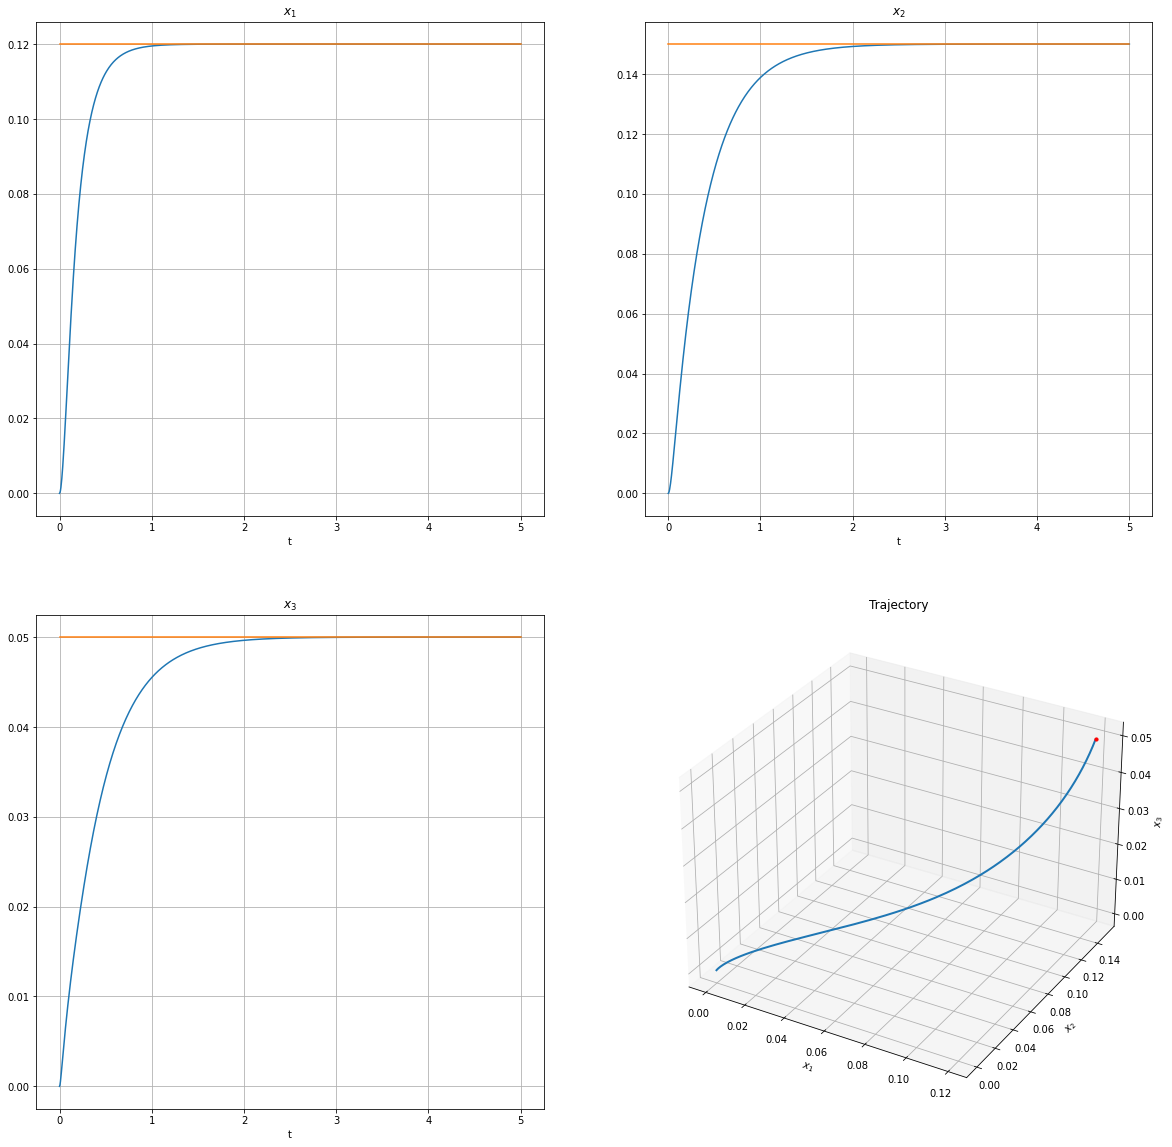

In [307]:
# Draw phases
(_,plots) = plot_3d(grid, end_effectors)
plots[0].plot(grid, target[0]*np.ones_like(grid))
plots[1].plot(grid, target[1]*np.ones_like(grid))
plots[2].plot(grid, target[2]*np.ones_like(grid))
plots[3].scatter(target[0], target[1], target[2], c="r",s = 10)

plt.show()

### График управления

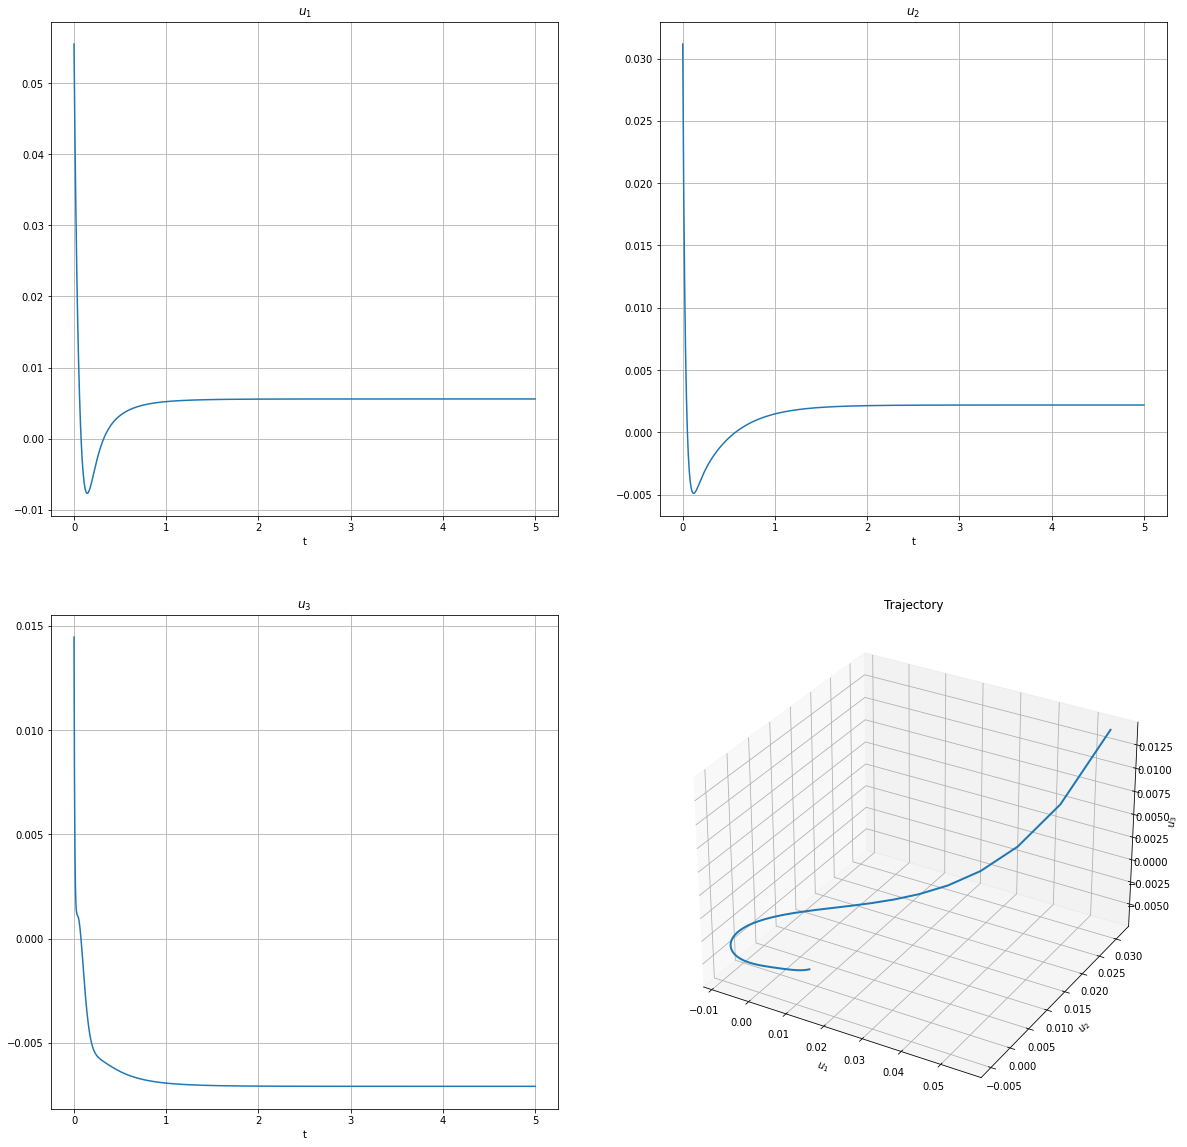

In [308]:
# Draw controls
(_,plots) = plot_3d(grid, controls, mesh_name="u")

plt.show()

## Стремящееся к траектории управление

### Управление

In [309]:
'''
    Kd : Kd=Kd', lambda > 0
'''
def tracking_control(robot:RobotIface, desired_path, lmbda:np.float32, kd:np.matrix):
    def result(state:np.array, t:np.float32):
        jacobian = robot.jacobian(state)
        inv_jacobian = np.linalg.inv(jacobian)
        d_jacobian = robot.d_jacobian(state)
        
        H = robot.inertia(state)
        Hx = inv_jacobian.T @ H @ inv_jacobian
        C = robot.coriolis(state)        
        Cx = (inv_jacobian.T @ C - Hx @ d_jacobian) @ inv_jacobian
        
        end_effector = np.reshape(robot.forward_kinematics(state), (3, 1))
        dX = jacobian@np.reshape(state[3:], (3,1))
        
        [Xd, dXd, d2Xd] = desired_path(t)
        
        u  =  Hx@(d2Xd - lmbda*(dX - dXd)) + Cx@(dXd - lmbda*(end_effector - Xd)) - kd@((dX - dXd) + lmbda*(end_effector - Xd)) 
        tau = jacobian.T @ u + robot.gravity(state)
        return tau
    return result

In [310]:
'''
    Часть условия задачи: траектория, к которой будет стремиться схват
'''
def desired_path(phantom: Phantom):
    def result(t):
        e = np.exp(-t)
        c = np.cos(t+2)
        s = np.sin(t+2)

        phases_size = 1
        if type(t) is type(np.array([])):
            phases_size = len(t)
        x = np.zeros((3, phases_size))

        dx = np.zeros_like(x)
        ddx = np.zeros_like(x)
        x[0, :] = phantom.l[0]*(0.6+e)
        x[1, :] = 0.1*phantom.l[1]*(1 - e)*s
        x[2, :] = 0.1*phantom.l[1]*(1 - e)*c
        dx[0, :] = -phantom.l[0]*e
        dx[1, :] = 0.1*phantom.l[1]*(e*s + (1-e)*c)
        dx[2, :] = 0.1*phantom.l[1]*(e*c - (1-e)*s)
        ddx[0, :] = phantom.l[0]*e
        ddx[1, :] = 0.1*phantom.l[1]*(2*e*c - s)
        ddx[2, :] = -0.1*phantom.l[1]*(2*e*s + c)
        return x, dx, ddx
    return result 


In [311]:
# Task
robot = Phantom()
time_from = 0; state_from = np.zeros(6)

# Solving and plot params
time_to = 20
grid = np.linspace(time_from, time_to, 1000)
control = tracking_control(robot, desired_path=desired_path(robot), lmbda=1, kd=np.diag([2, 2, 4]))

#Solve
def ode_system(time:np.float32, state:np.array) -> np.array:
    inv_inertia = np.linalg.inv(robot.inertia(state))

    result = np.zeros(6)
    result[:3] = state[3:]
    result[3:] = np.reshape(inv_inertia@((-robot.coriolis(state))@np.reshape(state[3:], (3,1)) - robot.gravity(state) + control(state, time)), 3)
    return result

ode_solver = integrate.ode(ode_system)
ode_solver.set_integrator('vode', method='bdf', order=15, nsteps=3000)
ode_solver.set_initial_value(state_from, time_from)

end_effectors = np.zeros((len(grid), 3)); controls = np.zeros_like(end_effectors)
for i in range(len(grid)):
    state = state_from
    if i>0:
        state = ode_solver.integrate(grid[i])
    end_effectors[i, :] = np.squeeze(robot.forward_kinematics(state))
    
    controls[i, :] = np.squeeze(np.transpose(robot.jacobian(state))@control(state, grid[i]))

### График траектории

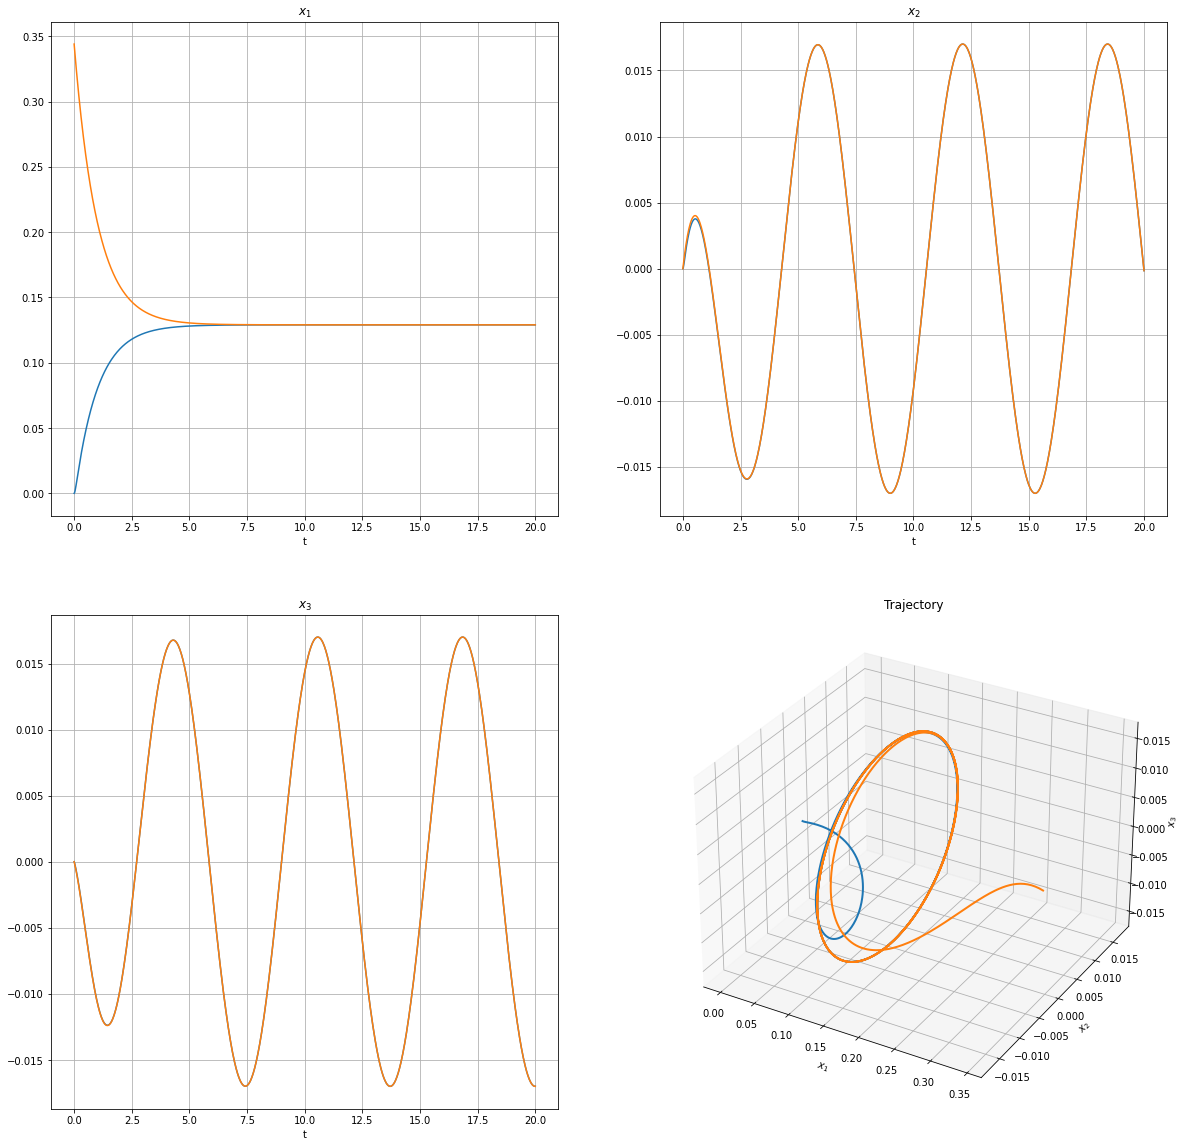

In [312]:
(_,plots) = plot_3d(grid, end_effectors)
path = desired_path(robot)(grid)
plots[0].plot(grid, path[0][0])
plots[1].plot(grid, path[0][1])
plots[2].plot(grid, path[0][2])
plots[3].plot(path[0][0], path[0][1], path[0][2], linewidth=2)
plt.show()


### График управления

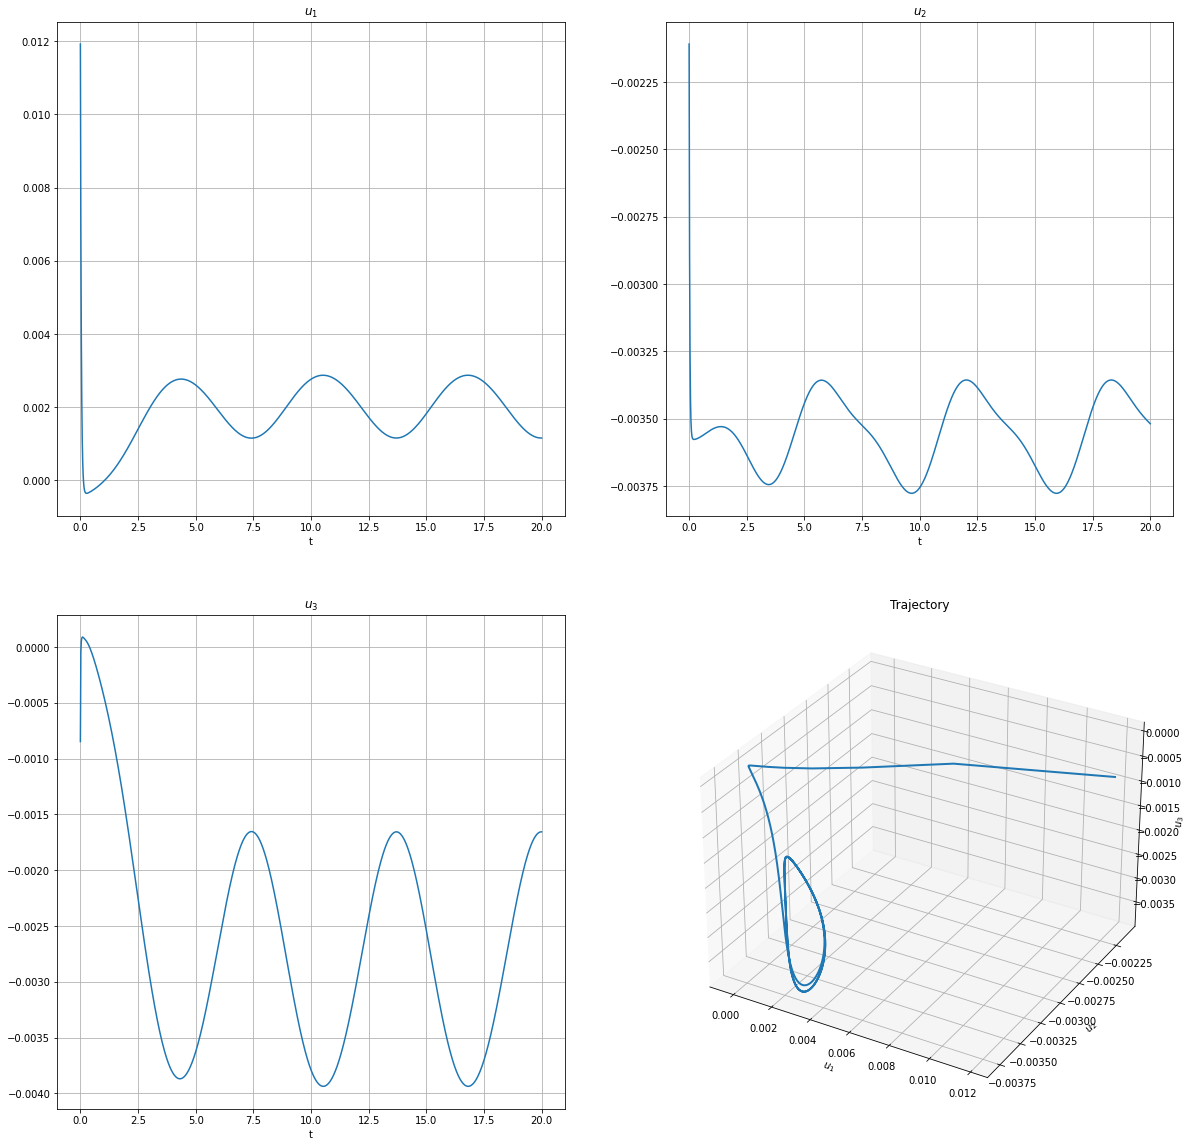

In [313]:
(_,plots) = plot_3d(grid, controls, mesh_name="u")

plt.show()

## Динамическое стремление к траектории

In [314]:
def adaptive_control(robot: RobotIface, desire_path, kp, kd):
    def result(full_state, t):
        state = full_state[:6]; param = full_state[6:]
        jacobian = robot.jacobian(state)
        inv_jacobian = np.linalg.inv(jacobian)
        d_jacobian = robot.d_jacobian(state)
        h_q = robot.inertia_p(state, param)
        h_x = inv_jacobian.T @ h_q @ inv_jacobian
        c_q = robot.coriolis_p(state, param)
        c_x = (inv_jacobian.T @ c_q - h_x @ d_jacobian) @ inv_jacobian
        end_effector = np.reshape(robot.forward_kinematics(state), (3,1))
        dX = jacobian @ np.reshape(state[3:], (3,1))
        Xd,dXd,d2Xd = desire_path(t)
        u0 = d2Xd - kp@(end_effector-Xd) - kd@(dX - dXd)
        u = h_x@u0 + c_x@dX
        tau = jacobian.T@u + robot.gravity_p(state, param)
        return tau
    return result

In [315]:
p1_0 = 1/8*(4*robot.i_ayy+4*robot.i_azz+8*robot.i_baseyy+4*robot.i_beyy+4*robot.i_bezz+4*robot.i_cyy+4*robot.i_czz +4*robot.i_dfyy+4*robot.i_dfzz+4*robot.l[0]**2*robot.m_a+robot.l[1]**2*robot.m_a+robot.l[0]**2*robot.m_c+4*robot.l[2]**2*robot.m_c)
p2_0 = 1/8*(4*robot.i_beyy-4*robot.i_bezz+4*robot.i_cyy-4*robot.i_czz+robot.l[0]**2*(4*robot.m_a+robot.m_c))
p3_0 = 1/8*(4*robot.i_ayy-4*robot.i_azz+4*robot.i_dfyy-4*robot.i_dfzz-robot.l[1]**2*robot.m_a-4*robot.l[2]**2*robot.m_c)
p4_0 = robot.l[0]*(robot.l[1]*robot.m_a+robot.l[2]*robot.m_c)
p5_0 = 1/4*(4*(robot.i_bexx+robot.i_cxx+robot.l[0]**2*robot.m_a)+robot.l[0]**2*robot.m_c)
p6_0 = 1/4*(4*robot.i_axx+4*robot.i_dfxx+robot.l[1]**2*robot.m_a+4*robot.l[2]**2*robot.m_c)
p7_0 = 1/2*robot.g*(2*robot.l[0]*robot.m_a+2*robot.l[4]*robot.m_be+robot.l[0]*robot.m_c)
p8_0 = 1/2*robot.g*(robot.l[1]*robot.m_a+2*robot.l[2]*robot.m_c-2*robot.l[5]*robot.m_df)
P0 = [p1_0, p2_0, p3_0, p4_0, p5_0, p6_0, p7_0, p8_0]

def regressor(robot, q, dq, d2q):
    Y = np.zeros((8, 3))
    Y[0, 0] = d2q[0]
    Y[1, 0] = d2q[0]*np.cos(2*q[1]) - 2*dq[0]*dq[1]*np.sin(q[1])*np.cos(q[1]) - dq[0]*dq[1]*np.sin(2*q[1])
    Y[1, 1] = dq[0]**2*np.sin(2*q[1])
    Y[2, 0] = d2q[0]*np.cos(2*q[2]) - 2*dq[0]*dq[2]*np.sin(q[2])*np.cos(q[2]) - dq[0]*dq[2]*np.sin(2*q[2])
    Y[2, 2] = dq[0]**2*np.sin(2*q[2])
    Y[3, 0] = d2q[0]*np.cos(q[1])*np.sin(q[2]) - dq[0]*dq[1]*np.sin(q[1])*np.sin(q[2]) + dq[0]*dq[2]*np.cos(q[1])*np.cos(q[2])
    Y[3, 1] = -(1/2)*d2q[2]*np.sin(q[1]-q[2]) + (1/2)*dq[0]**2*np.sin(q[1])*np.sin(q[2]) + (1/2)*dq[2]**2*np.cos(q[1]-q[2])
    Y[3, 2] = -(1/2)*d2q[1]*np.sin(q[1]-q[2]) - (1/2)*dq[0]**2*np.cos(q[1])*np.cos(q[2]) + (1/2)*dq[1]**2*np.cos(q[1]-q[2])
    Y[4, 1] = d2q[1]
    Y[5, 2] = d2q[2]
    Y[6, 1] = np.cos(q[1])
    Y[7, 2] = np.sin(q[2])
    
    iJ = np.linalg.inv(robot.jacobian(q))
    return iJ.T@Y.T

Gamma = np.diag([0.75, 1.2, 1.3, 1.5, 1, 0.8, 0.6, 1.2])
Kp = np.diag([2, 4, 6])
Kd = np.diag([4, 10, 10])
M = np.eye(6)
A = np.concatenate((np.concatenate((np.zeros((3, 3)), np.eye(3)), axis=1), np.concatenate((-Kp, -Kd), axis=1)))
L = linalg.solve_lyapunov(A.T, -M)
B = np.concatenate((np.zeros((3, 3)), np.eye(3)))

control = adaptive_control(robot, desire_path=desired_path(robot), kp=Kp, kd=Kd)
state_from = np.concatenate((np.zeros(6), P0))

def ode_system(time:np.float32, full_state:np.array) -> np.array:
    tau = control(full_state, time)
    state = full_state[:6]; param = full_state[6:]
   
    G_q = robot.gravity_p(state, param)
    iH = np.linalg.inv(robot.inertia_p(state, param))
    iGamma = np.linalg.inv(Gamma)
    
    dq = np.zeros((14, 1))
    dq[:3, 0] = state[3:].reshape(3)
    dq[3:6, 0] = np.reshape(iH@(-robot.coriolis_p(state, param)@(state[3:].reshape((3, 1))) - G_q + tau), 3)
   
    J_q = robot.jacobian(state)
    X = np.reshape(robot.forward_kinematics(state), (3,1))
    dX = J_q@(state[3:].reshape((3, 1)))
    iH_x = J_q@iH@J_q.T

    Y = regressor(robot, state[:3], state[3:], np.squeeze(dq[3:6, 0]))
    
    Xd,dXd,d2Xd = desired_path(robot)(time)
    dq[6:, 0] = np.reshape(-iGamma@Y.T@iH_x@B.T@L@(np.concatenate((X, dX))-np.concatenate((Xd, dXd))), 8)
    
    return dq[:, 0]

ode_solver = integrate.ode(ode_system)
ode_solver.set_integrator('vode', method='bdf', order=15, nsteps=3000)
ode_solver.set_initial_value(state_from, time_from)

end_effectors = np.zeros((len(grid), 3)); controls = np.zeros_like(end_effectors)
for i in range(len(grid)):
    state = state_from
    if i>0:
        state = ode_solver.integrate(grid[i])
    end_effectors[i, :] = np.squeeze(robot.forward_kinematics(state))
    
    controls[i, :] = np.squeeze(np.transpose(robot.jacobian(state))@control(state, grid[i]))

### График траектории

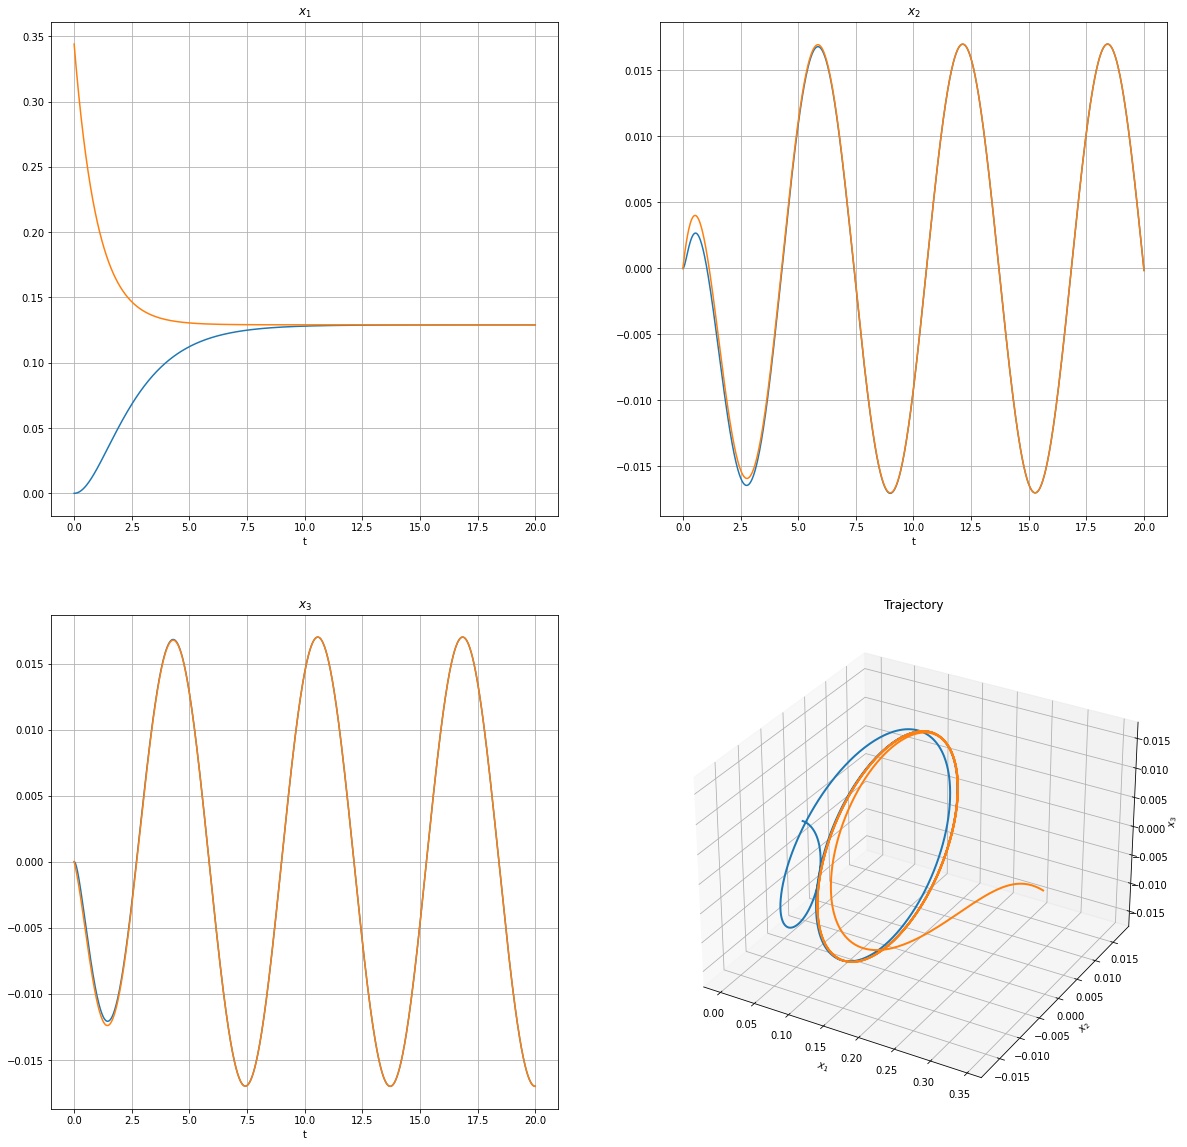

In [316]:
(_,plots) = plot_3d(grid, end_effectors)
path = desired_path(robot)(grid)
plots[0].plot(grid, path[0][0])
plots[1].plot(grid, path[0][1])
plots[2].plot(grid, path[0][2])
plots[3].plot(path[0][0], path[0][1], path[0][2], linewidth=2)
plt.show()

### График управления

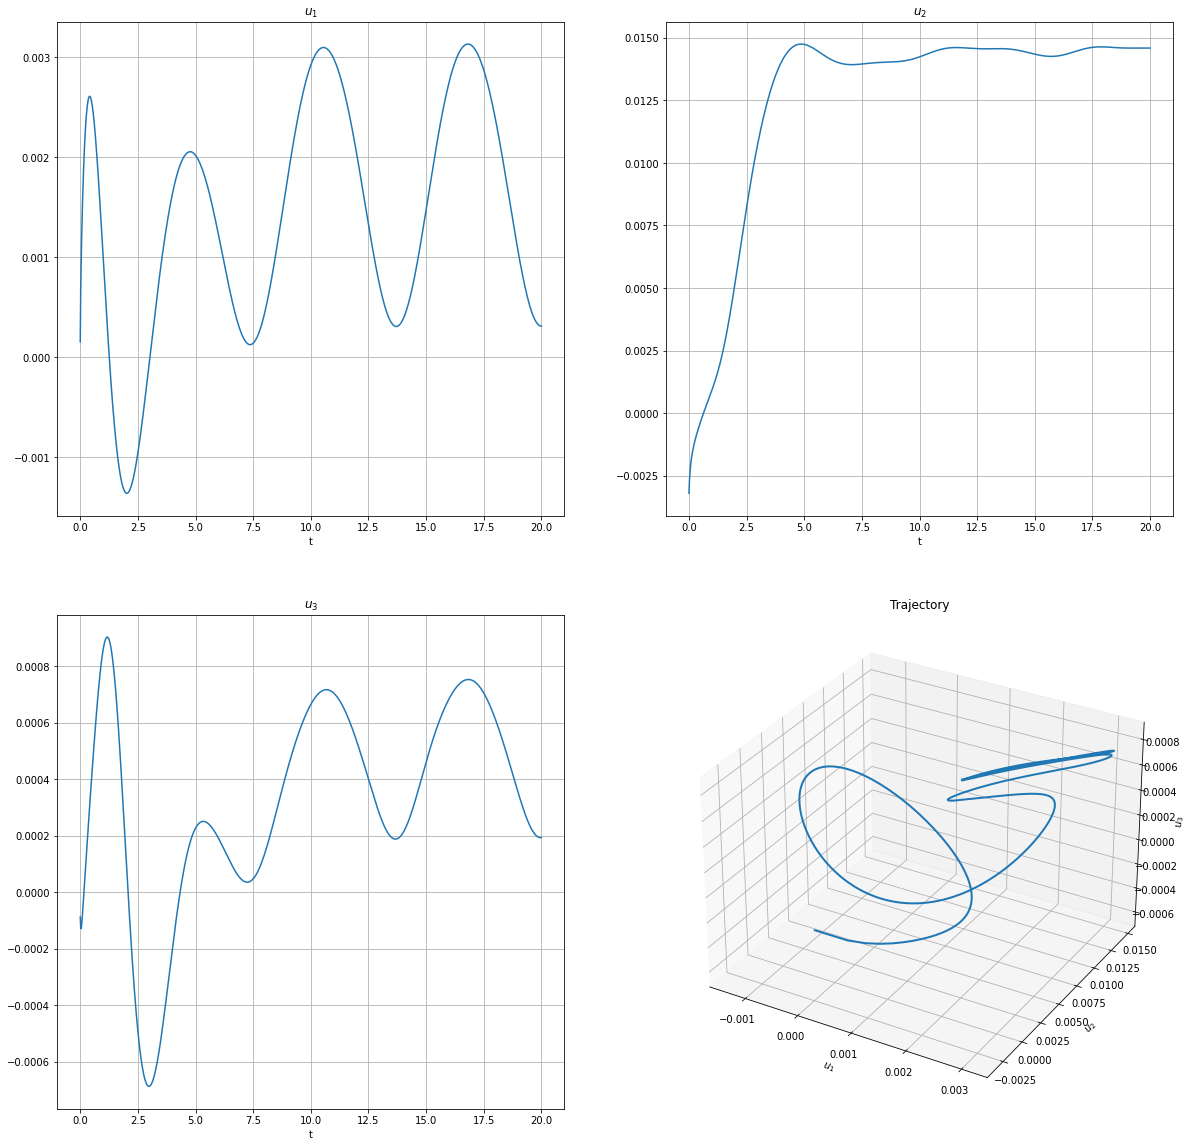

In [317]:
(_,plots) = plot_3d(grid, controls, mesh_name="u")

plt.show()
